In [863]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [864]:
import os
import torch as ch
import numpy as np
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import torch.nn as nn

import matplotlib.pyplot as plt

from mib.models.utils import get_model
from mib.dataset.utils import get_dataset
from mib.attacks.utils import get_attack
from mib.utils import get_signals_path, get_models_path
from mib.attacks.theory import compute_trace
from mib.attacks.attack_utils import compute_scaled_logit, compute_gradients
from mib.attacks.batchnorm import get_bn_stats

In [865]:
# bn_stats_mem = get_bn_stats(main_model, member_loader, flipped_also=True)

In [841]:
import matplotlib as mpl
import matplotlib.font_manager as fm

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams["font.family"] = "Times New Roman"

In [235]:
def load_models(paths):
    ref_indices, ref_models = [], []
    for path in paths:
        if os.path.isdir(path):
            continue
        model, _, _ = get_model(model_arch, 10)
        state_dict = ch.load(path)
        ref_indices.append(state_dict["train_index"])
        model.load_state_dict(state_dict["model"], strict=False)
        model.eval()
        ref_models.append(model)

    ref_indices = np.array(ref_indices, dtype=object)
    return ref_models, ref_indices

In [133]:
def member_nonmember_loaders(
    train_data,
    train_idx,
    num_nontrain_pool: int = None,
    batch_size: int = 1,
    want_all_member_nonmember: bool = False,
):
    seed = 2024
    num_points = 500
 
    other_indices_train = np.array(
        [i for i in range(len(train_data)) if i not in train_idx]
    )

    # Create Subset datasets for members
    if want_all_member_nonmember:
        train_index_subset = train_idx
    else:
        np.random.seed(seed)
        train_index_subset = np.random.choice(train_idx, num_points, replace=False)

    # Sample non-members
    np.random.seed(seed + 1)
    nonmember_indices = np.random.choice(
        other_indices_train, num_nontrain_pool, replace=False
    )

    if want_all_member_nonmember:
        nonmember_index_subset = nonmember_indices
    else:
        # Break nonmember_indices here into 2 - one for sprinkling in FT data, other for actual non-members
        nonmember_indices_ft = nonmember_indices[: num_nontrain_pool // 2]
        nonmember_indices_test = nonmember_indices[num_nontrain_pool // 2 :]

        nonmember_dset_ft = ch.utils.data.Subset(train_data, nonmember_indices_ft)

        # Sample non-members
        np.random.seed(seed + 2)
        nonmember_index_subset = np.random.choice(
            nonmember_indices_test, num_points, replace=False
        )

    # Make dsets
    member_dset = ch.utils.data.Subset(train_data, train_index_subset)
    nonmember_dset = ch.utils.data.Subset(
        train_data,
        nonmember_index_subset,
    )

    # Make loaders out of data
    member_loader = ch.utils.data.DataLoader(
        member_dset, batch_size=batch_size, shuffle=False
    )
    nonmember_loader = ch.utils.data.DataLoader(
        nonmember_dset, batch_size=batch_size, shuffle=False
    )

    if want_all_member_nonmember:
        return member_loader, nonmember_loader
    return (
        member_loader,
        nonmember_loader,
        nonmember_dset_ft,
        train_index_subset,
        nonmember_index_subset,
    )

In [240]:
ds = get_dataset("cifar10")(augment=False)
# CIFAR
num_nontrain_pool = 10000

# Get data
train_data = ds.get_train_data()

(
    member_loader,
    nonmember_loader,
    nonmember_dset_ft,
    train_index_subset,
    nonmember_index_subset,
) = member_nonmember_loaders(
    train_data,
    main_index,
    num_nontrain_pool
)

Files already downloaded and verified
Files already downloaded and verified


In [241]:
model_arch = "wide_resnet_28_2"

model_path_overall = f"/p/distinf/mib_cache/models/{model_arch}"
model_path_main = f"{model_path_overall}/0.pt" # Original model

In [242]:
main_model, main_index = load_models([model_path_main])
main_model = main_model[0]
main_index = main_index[0]

In [243]:
# Also load general ref models
model_paths = [os.path.join(model_path_overall, x) for x in os.listdir(model_path_overall)]
ref_models_overall, ref_indices_overall = load_models(model_paths)

In [244]:
# And take note of in and out models. We want to see how their trends are, compared to the LOO setting
member_map = np.zeros((len(ref_models_overall), len(train_index_subset)), dtype=bool)
nonmember_map = np.zeros((len(ref_models_overall), len(nonmember_index_subset)), dtype=bool)
for i, out_index in enumerate(ref_indices_overall):
    member_map[i]    = np.isin(train_index_subset, out_index)
    nonmember_map[i] = np.isin(nonmember_index_subset, out_index)

### Batch-norm distance analysis

In [755]:
@ch.no_grad()
def get_losses(m, ldr):
    l = nn.CrossEntropyLoss(reduction='none')
    ls = []
    for a, b in ldr:
        #o = m(a)
        # score = l(o, b).cpu().numpy()
        score = compute_scaled_logit(m, a.cuda(), b.cuda())
        ls.append(score)
    return np.concatenate(ls, 0)

In [756]:
# Get loss values for loaders
losses_mem = get_losses(main_model, member_loader)
losses_nonmem = get_losses(main_model, nonmember_loader)

In [871]:
bn_stats_mem    = get_bn_stats(main_model, member_loader,    flipped_also=True)
bn_stats_nonmem = get_bn_stats(main_model, nonmember_loader, flipped_also=True)

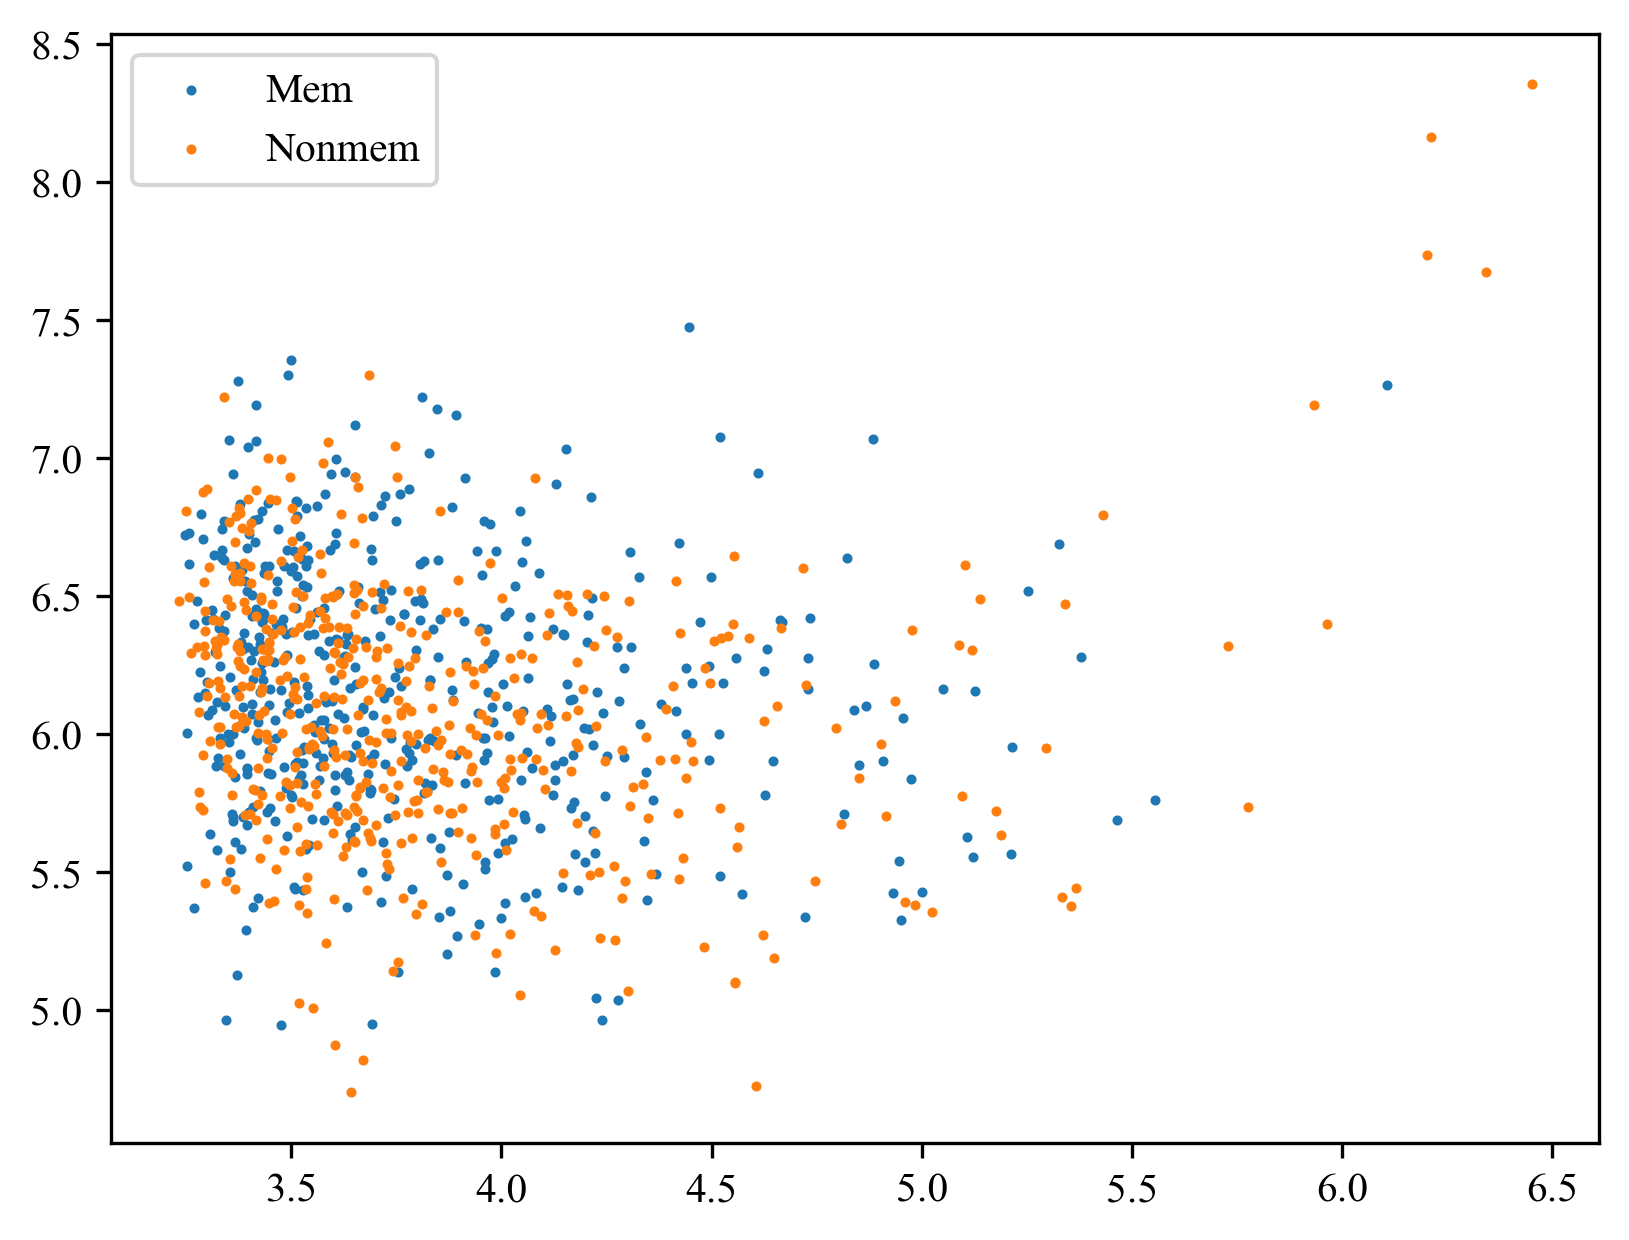

In [897]:
picked_bn = [0, 1]
plt.scatter(bn_stats_mem[:, picked_bn[0]], bn_stats_mem[:, picked_bn[1]], label="Mem", s=2)
plt.scatter(bn_stats_nonmem[:, picked_bn[0]], bn_stats_nonmem[:, picked_bn[1]], label="Nonmem", s=2)
plt.legend()

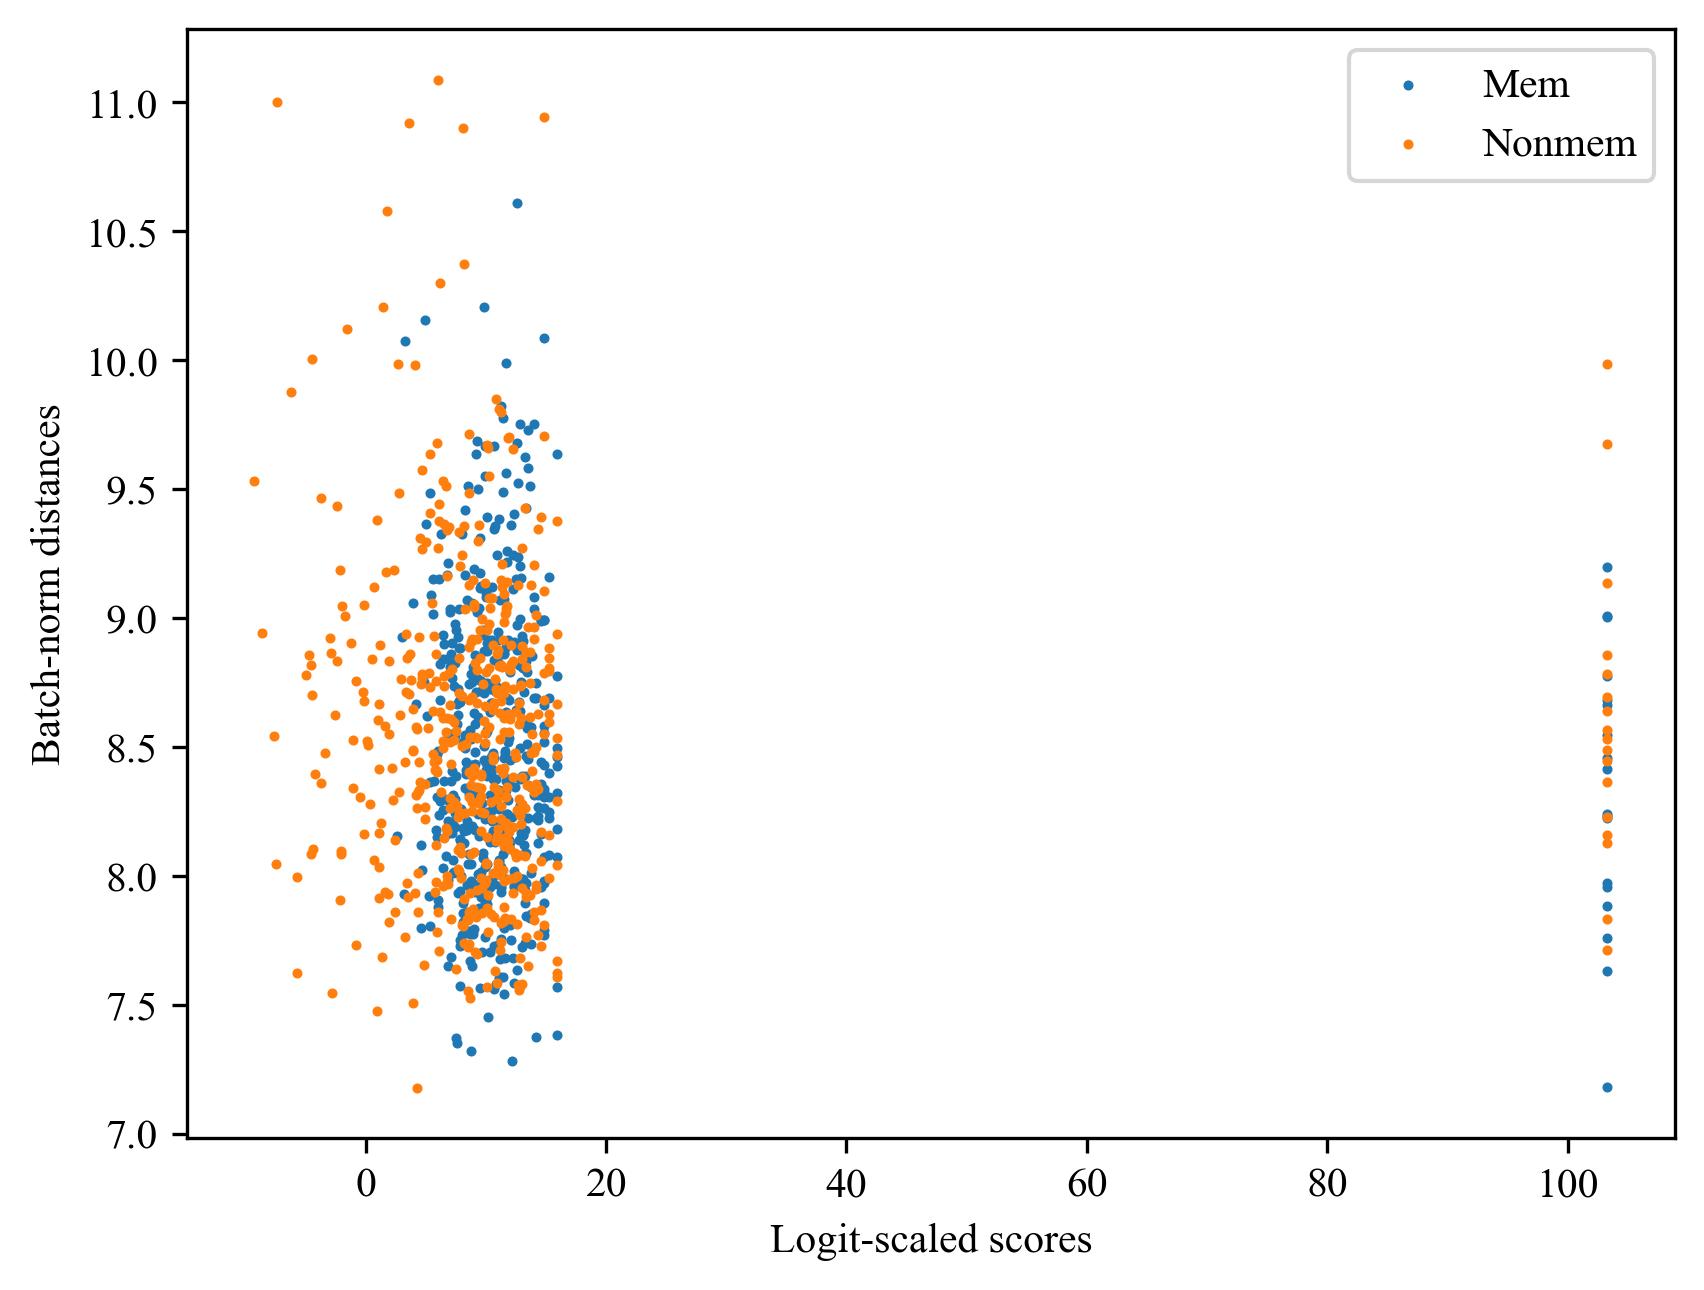

In [933]:
picked_bn = 13 #13
# plt.scatter(losses_mem, np.mean(bn_stats_mem[:, :15], 1), label="Mem", s=2)
# plt.scatter(losses_nonmem, np.mean(bn_stats_nonmem[:, :15], 1), label="Nonmem", s=2)
plt.scatter(losses_mem, bn_stats_mem[:, picked_bn], label="Mem", s=2)
plt.scatter(losses_nonmem, bn_stats_nonmem[:, picked_bn], label="Nonmem", s=2)
plt.xlabel("Logit-scaled scores")
plt.ylabel("Batch-norm distances")
plt.legend()
# print(np.where(bn_stats_nonmem[:, picked_bn] >= 7.5)[0])

<AxesSubplot: xlabel='value', ylabel='Probability'>

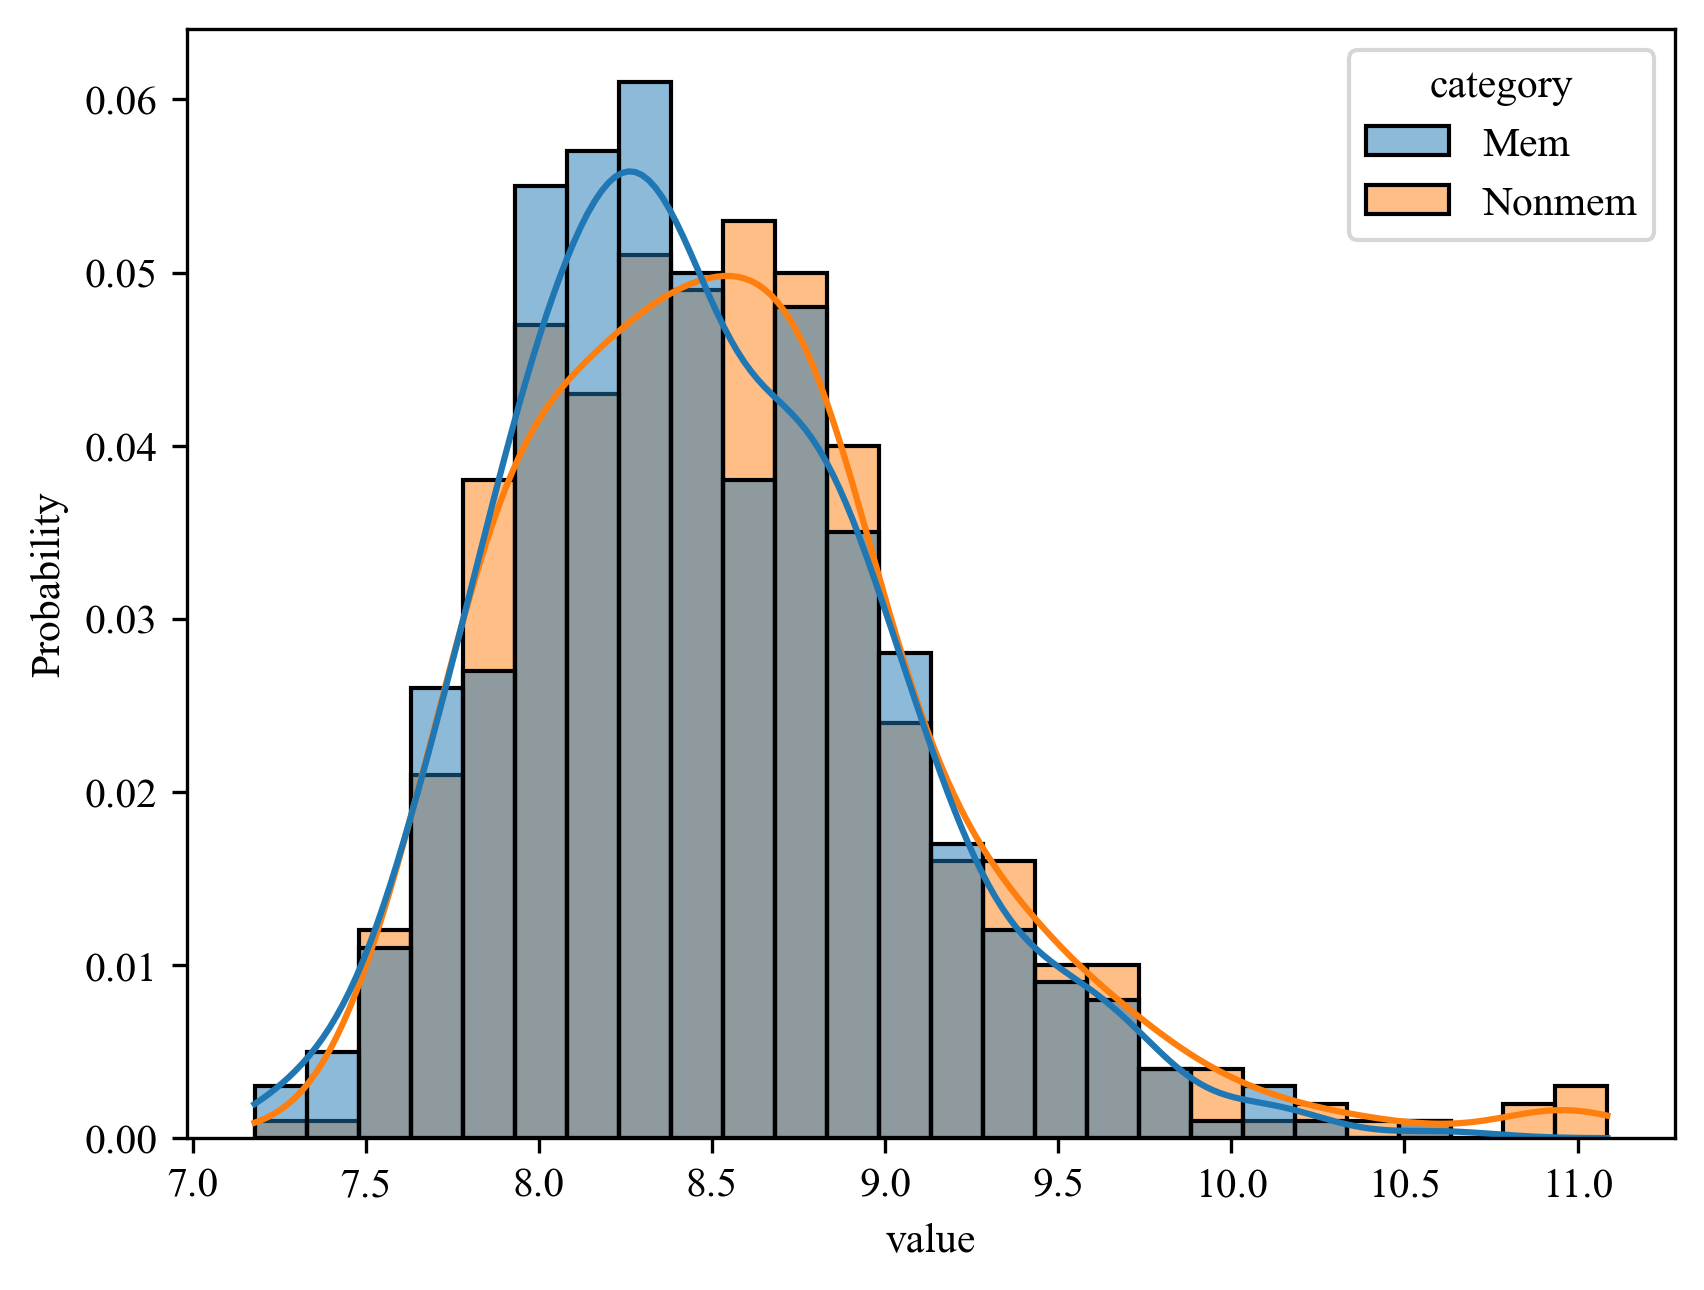

In [934]:
picked_bn = 13
data = pd.DataFrame({
    'value': np.concatenate([bn_stats_mem[:,picked_bn] , bn_stats_nonmem[:, picked_bn]]),
    'category': ['Mem']*len(bn_stats_mem) + ['Nonmem']*len(bn_stats_nonmem)
})

sns.histplot(data=data, x='value', hue='category', stat='probability', kde=True)

### Activaiton analysis for members and non-members

In [395]:
def acts(loader):
    lp = 3
    collect = []
    for z, _ in loader:
        acts_c = main_model(z, layer_readout=lp).detach().numpy()
        acts_c = acts_c.reshape(acts_c.shape[0], -1)
        acts_c = (acts_c > 0)
        collect.append(acts_c)
    collect = np.concatenate(collect, 0)
    return collect

In [396]:
acts_mem = acts(member_loader)
acts_nonmem = acts(nonmember_loader)

In [397]:
from scipy.spatial.distance import cdist

# Intra member overlap
intra_mem = 1 - cdist(acts_mem * 1., acts_mem * 1., metric='cosine')
# Intra non-member overlap
intra_nonmem = 1 - cdist(acts_nonmem * 1., acts_nonmem * 1., metric='cosine')
# Member-nonmember overlap
inter_mem_nonmem = 1 - cdist(acts_mem * 1., acts_nonmem * 1., metric='cosine')

In [398]:
intra_mem = intra_mem[np.triu_indices(intra_mem.shape[0])]
intra_nonmem = intra_nonmem[np.triu_indices(intra_nonmem.shape[0])]
inter_mem_nonmem = inter_mem_nonmem[np.triu_indices(inter_mem_nonmem.shape[0])]

<AxesSubplot: xlabel='value', ylabel='Probability'>

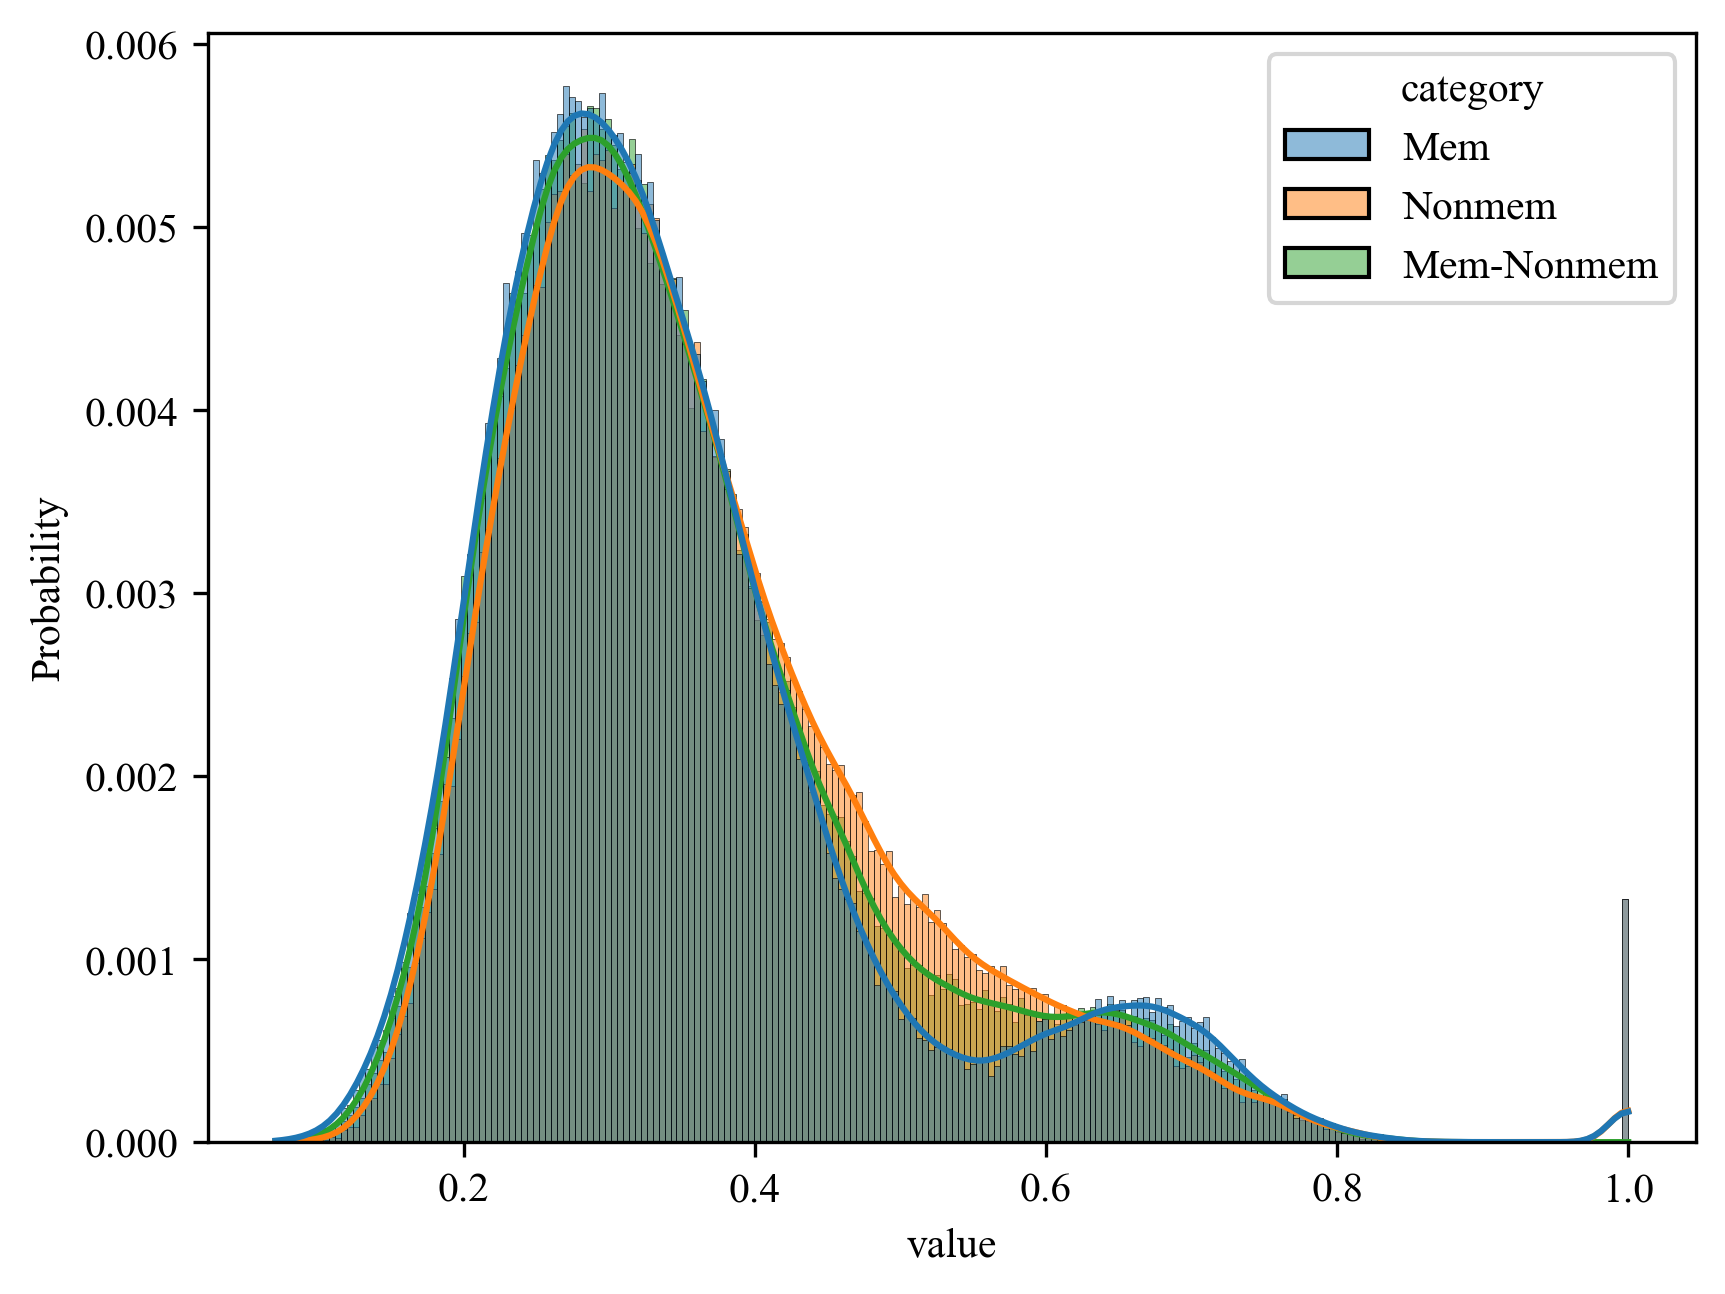

In [399]:
data = pd.DataFrame({
    'value': np.concatenate([intra_mem, intra_nonmem, inter_mem_nonmem]),
    'category': ['Mem']*len(intra_mem) + ['Nonmem']*len(intra_nonmem) + ['Mem-Nonmem']*len(inter_mem_nonmem) 
})

sns.histplot(data=data, x='value', hue='category', stat='probability', kde=True)

In [400]:
data = pd.DataFrame({
    'value': np.concatenate([acts_mem, acts_nonmem]),
    'category': ['In']*len(acts_mem) + ['Out']*len(acts_nonmem) 
})

sns.histplot(data=data, x='value', hue='category', stat='probability', kde=True)

ValueError: Per-column arrays must each be 1-dimensional

### Datapoint-specific parts

In [312]:
inspect_i = 1

In [313]:
ref_models_in  = [ref_models_overall[i] for i in np.nonzero(member_map[:, inspect_i])[0]]
ref_models_out = [ref_models_overall[i] for i in np.nonzero(1 - member_map[:, inspect_i])[0]]

In [314]:
# Models trained on all data except record inspect_i
ref_path = f"/p/distinf/mib_cache/models/{model_arch}/l_mode/0/{inspect_i}/last_5"
model_paths = [os.path.join(ref_path, x) for x in os.listdir(ref_path)]

In [315]:
ref_models, ref_indices = load_models(model_paths)

In [316]:
# Get inspect_i'th point from loader
for i, (x, y) in enumerate(member_loader):
    if i == inspect_i:
        member_x, member_y = x, y
        print(f"Loaded points at position {inspect_i}")
        break

Loaded points at position 1


In [317]:
for r in ref_indices:
    assert len(set(main_index) - set(r)) == 1

In [ ]:
def get_loss(m):
    # Get "metric" for given model on point (x, y)
    criterion = ch.nn.CrossEntropyLoss(reduction="mean", label_smoothing=0)
    return criterion(m(member_x), member_y).detach().numpy()

In [ ]:
metric_base = get_loss(main_model)
metric_l   = np.array([get_activations(m, layer) for m in ref_models])
metric_in  = np.array([get_activations(m, layer) for m in ref_models_in])
metric_out = np.array([get_activations(m, layer) for m in ref_models_out])

data = pd.DataFrame({
    'value': np.concatenate([metric_l, metric_out, metric_in]),
    'category': ['Out (L)']*len(metric_l) + ['Out']*len(metric_out) + ['In']*len(metric_in)
})

sns.histplot(data=data, x='value', hue='category', stat='probability', bins=10)

print(metric_base)
print(np.mean(metric_base > metric_others))

29/50 models (60%) have a loss on point (x, y) lower than a model that actually saw (x, y), despite these reference models not being trained on the point (x, y)! 

In [ ]:
def get_gradient(m, pick: int = None):
    pick = 107
    criterion = ch.nn.CrossEntropyLoss(reduction="mean", label_smoothing=0)
    grads = compute_gradients(m, criterion, member_x, member_y, pick_specific_layer=pick)
    # Return L2 norm of grad
    return np.linalg.norm(grads)

In [ ]:
metric_base = get_gradient(main_model)
metric_others = np.array([get_gradient(m) for m in ref_models])

In [ ]:
take_note = []
for layer_i in tqdm(range(108)):
    metric_base = get_gradient(main_model, layer_i)
    metric_others = np.array([get_gradient(m, layer_i) for m in ref_models])
    m = np.mean(metric_base > metric_others)
    take_note.append(max(m, 1-m))

plt.plot(np.arange(len(take_note)), take_note)

In [148]:
metric_base = get_gradient(main_model)
metric_others = np.array([get_gradient(m) for m in ref_models])

2.6795297e-07
0.22


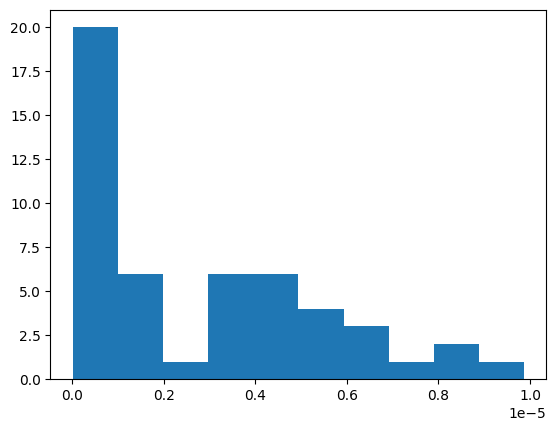

In [149]:
plt.hist(metric_others, bins=10)
print(metric_base)
print(np.mean(metric_base > metric_others))

The same trend seems to hold for gradient norms!

In [290]:
def get_activations(m, pick: int = None):
    act = m(member_x, layer_readout=pick).detach().numpy()
    return np.mean(act > 0)

In [345]:
layer = 0

2.3841855e-07
0.0


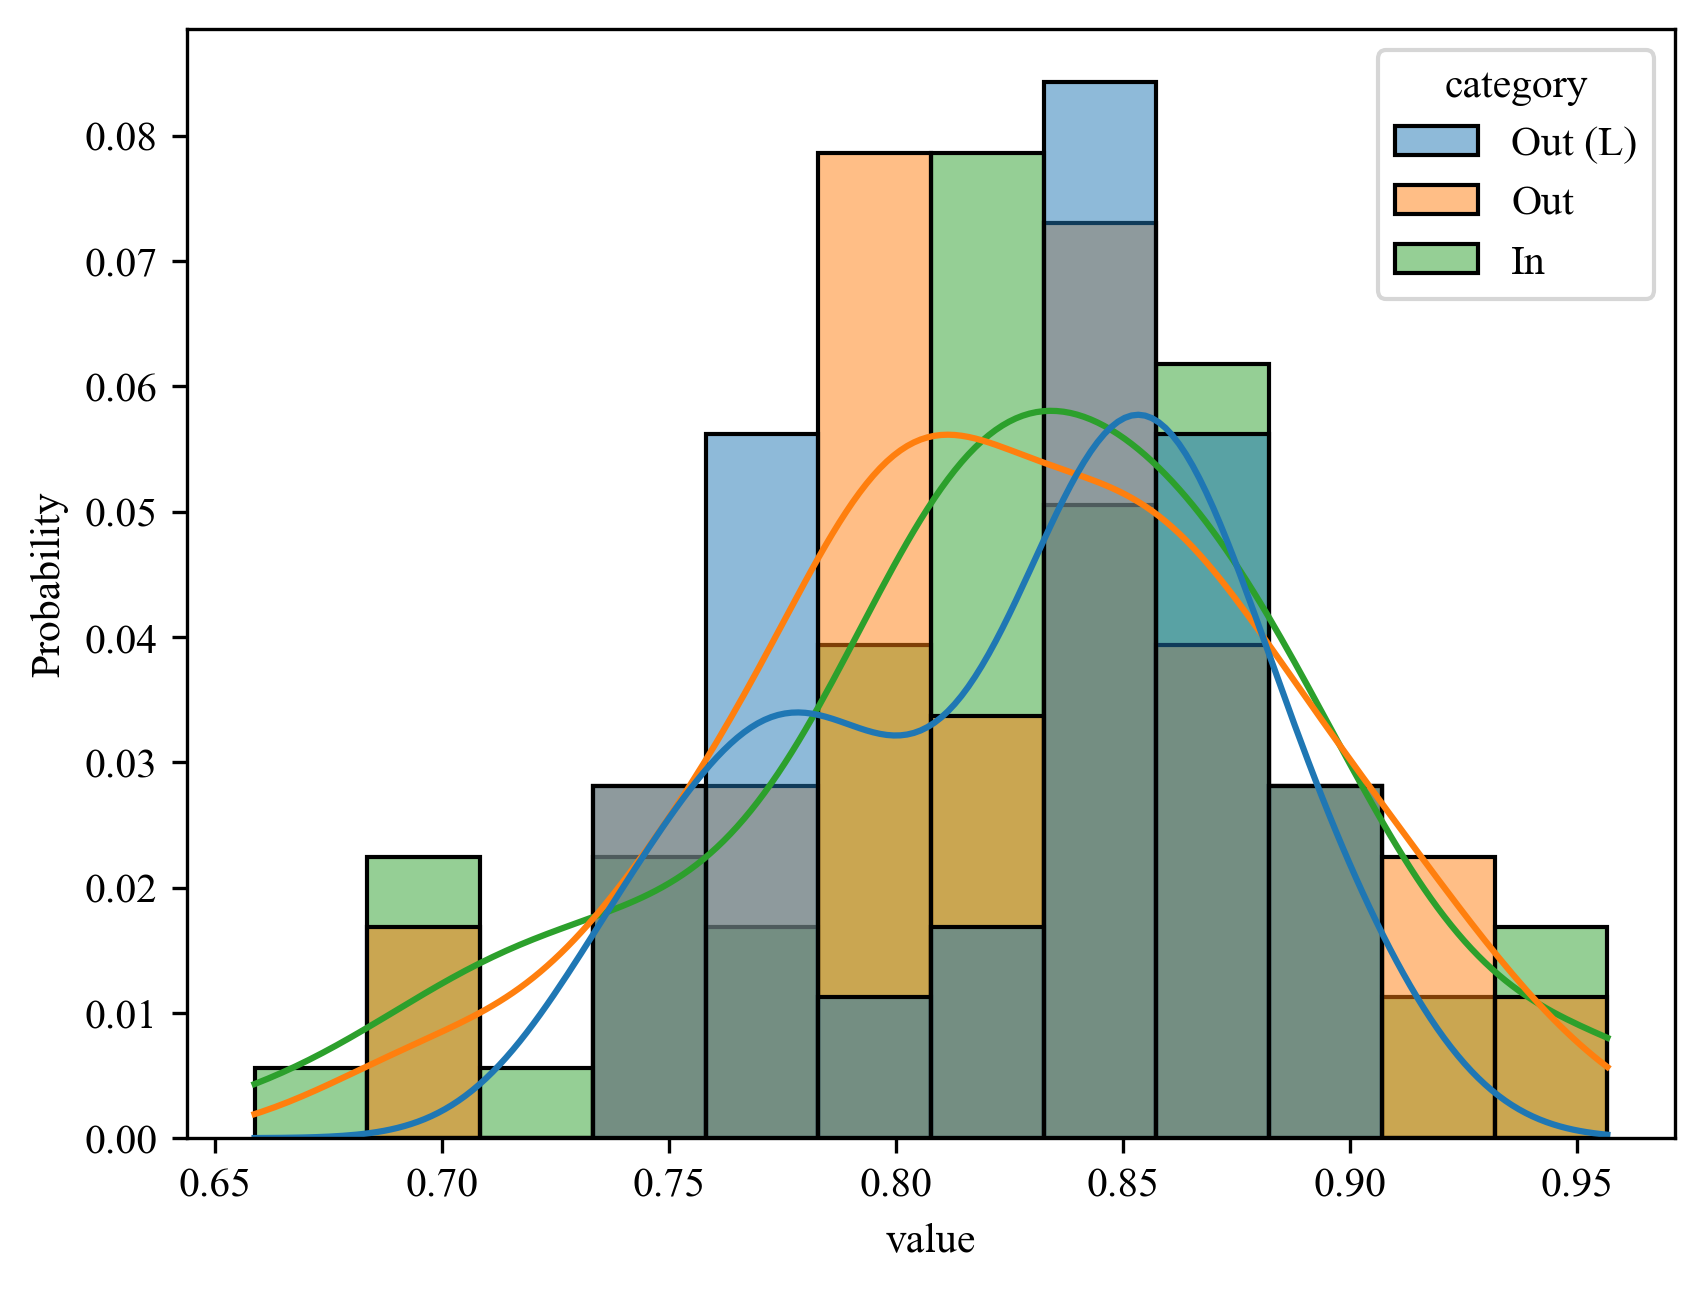

In [346]:
metric_base = get_loss(main_model)
metric_l   = np.array([get_activations(m, layer) + get_activations(m, layer+2) for m in ref_models])
metric_out = np.array([get_activations(m, layer) + get_activations(m, layer+2) for m in ref_models_out])
metric_in  = np.array([get_activations(m, layer) + get_activations(m, layer+2) for m in ref_models_in])

data = pd.DataFrame({
    'value': np.concatenate([metric_l, metric_out, metric_in]),
    'category': ['Out (L)']*len(metric_l) + ['Out']*len(metric_out) + ['In']*len(metric_in)
})

sns.histplot(data=data, x='value', hue='category', stat='probability', kde=True)

print(metric_base)
print(np.mean(metric_base > metric_others))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.62it/s]


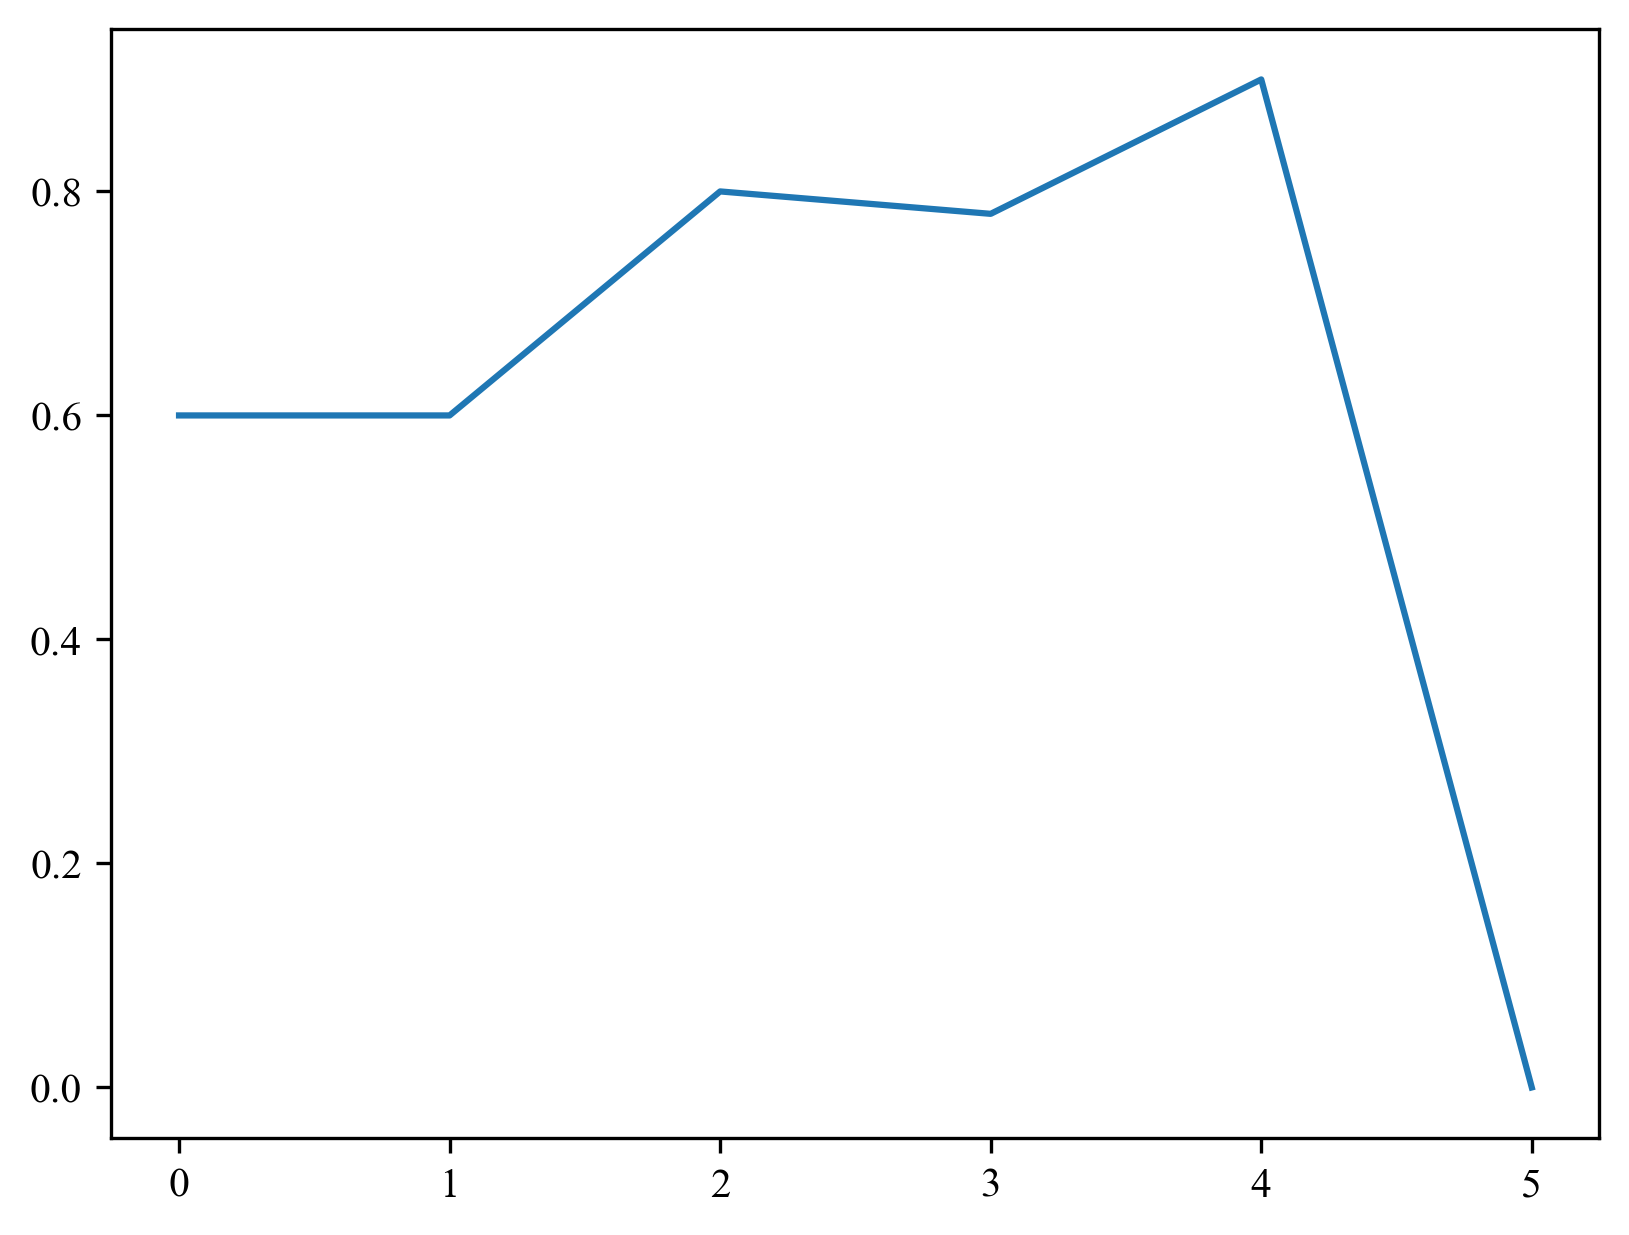

In [322]:
take_note = []
for layer_i in tqdm(range(6)):
    metric_base = get_activations(main_model, layer_i)
    metric_others = np.array([get_activations(m, layer_i) for m in ref_models])
    m = np.mean(metric_base > metric_others)
    note = max(m, 1-m)
    note -= np.mean(metric_base == metric_others)
    take_note.append(note)

plt.plot(np.arange(len(take_note)), take_note)

It's not clear if the lack of alignment between models is at play here, but looks like for most layers (except penultimate layer block's output), there is a consistent trend of model trained with (x, y) having activation trends (just noted non-zero activations) such that they get less distinguishable towards the end of the model

**Next step**: pick up reference models trained on "other" data and see where they stand, and also bring into the picture other models trained with the point (x, y), but with other points being randomly selected